In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [91]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0

In [74]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='selu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [75]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [76]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='selu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


In [77]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
    # return xent_loss


In [78]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

In [79]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [92]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s - loss: 146.6585 - val_loss: 152.5801
Epoch 2/20
60000/60000 [==============================] - 8s - loss: 146.6892 - val_loss: 152.7207
Epoch 3/20
60000/60000 [==============================] - 8s - loss: 146.5864 - val_loss: 152.2776
Epoch 4/20
60000/60000 [==============================] - 8s - loss: 146.6202 - val_loss: 152.5021
Epoch 5/20
60000/60000 [==============================] - 8s - loss: 146.5887 - val_loss: 152.4844
Epoch 6/20
60000/60000 [==============================] - 8s - loss: 146.5895 - val_loss: 152.7992
Epoch 7/20
60000/60000 [==============================] - 8s - loss: 146.5203 - val_loss: 152.9138
Epoch 8/20
60000/60000 [==============================] - 8s - loss: 146.5907 - val_loss: 152.8990
Epoch 9/20
60000/60000 [==============================] - 8s - loss: 146.5227 - val_loss: 152.8303
Epoch 10/20
60000/60000 [==============================] - 

In [81]:
# print(x_train)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

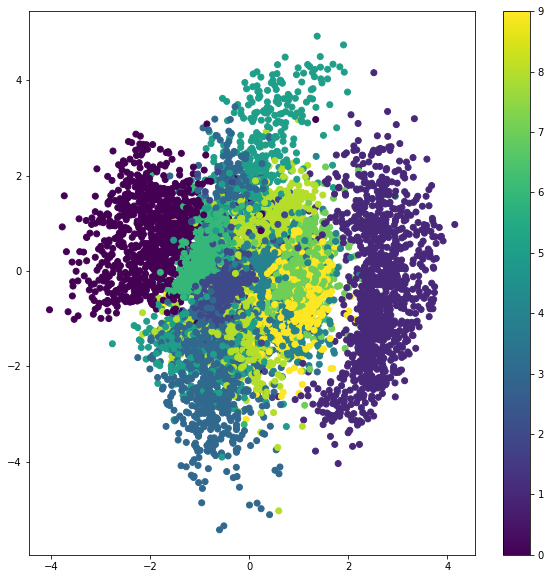

In [93]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show() 

In [83]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean) 

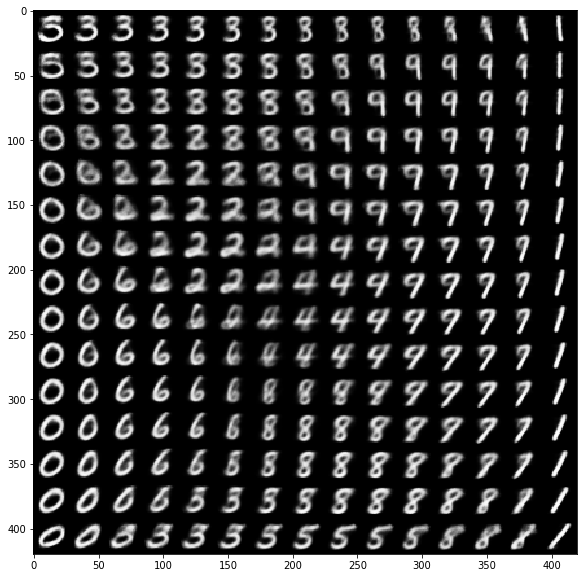

In [94]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))
#min_x = min(x_test_encoded[:, 0])
#max_x = max(x_test_encoded[:, 0])
#min_y = min(x_test_encoded[:, 1])
#max_y = max(x_test_encoded[:, 1])
#grid_x = np.linspace(min_x, max_x, n)
#grid_y = np.linspace(min_y, max_y, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # print(xi, yi)
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()